# Based on: Explain Attacking BERT models using CAptum

Captum is a PyTorch library to explain neural networks
Here we show a minimal example using Captum to explain BERT models from TextAttack

[![Open Notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yifengd/adversarial-nlp/defenses/captum/catum.ipynb)

[![Original Code on GitHub](https://img.shields.io/badge/github-view%20source-black.svg)](https://github.com/QData/TextAttack/blob/master/docs/2notebook/Example_5_Explain_BERT.ipynb)

In [2]:
!pip install textattack[tensorflow] tensorflow_text==2.10.0b2 captum -q

In [1]:
import torch
from copy import deepcopy
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from textattack.datasets import HuggingFaceDataset
from textattack.models.wrappers import HuggingFaceModelWrapper
from textattack.models.wrappers import ModelWrapper
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else: 
    device = torch.device("cpu")
    
print(f"Using accelerator {device}")

Using accelerator cuda:0


## Configure Model and Dataset

In [3]:
dataset = HuggingFaceDataset("ag_news", None, "train")
original_model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-ag-news")
original_tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-ag-news")
model = HuggingFaceModelWrapper(original_model,original_tokenizer)

Using custom data configuration default
Reusing dataset ag_news (/root/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a)
textattack: Loading datasets dataset ag_news, split train.


## Perform TextAttack

In [16]:
from textattack.attack_recipes import PWWSRen2019
attack = PWWSRen2019.build(model)

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [23]:
from textattack import Attacker
from textattack import AttackArgs

attacker = Attacker(attack, dataset, attack_args=AttackArgs(num_successful_examples=100, parallel=True))
results = attacker.attack_dataset()

textattack: Running 1 worker(s) on 1 GPU(s).
textattack: Worklist size: 100
textattack: Worklist candidate size: 119900

  1%|          | 1/100 [00:11<18:24, 11.15s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   1%|          | 1/100 [00:11<18:26, 11.17s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Sci/tech (68%)]]

Wall St. [[Bears]] Claw Back Into the [[Black]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. [[suffer]] Claw Back Into the [[lightlessness]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindle]]\[[isthmus]] of ultra-cynics, are [[examine]] [[greenish]] again.



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   2%|▏         | 2/100 [00:16<13:35,  8.33s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:   2%|▏         | 2/100 [00:16<13:36,  8.33s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.



[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:   3%|▎         | 3/100 [00:20<11:16,  6.97s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:   3%|▎         | 3/100 [00:20<11:16,  6.98s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.



[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:   4%|▍         | 4/100 [00:25<10:11,  6.37s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:   4%|▍         | 4/100 [00:25<10:11,  6.37s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.



[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:   5%|▌         | 5/100 [00:30<09:38,  6.08s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:   5%|▌         | 5/100 [00:30<09:38,  6.09s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:   6%|▌         | 6/100 [00:38<10:00,  6.38s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:   6%|▌         | 6/100 [00:38<10:00,  6.39s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (55%)]]

[[Stocks]] [[End]] [[Up]], But Near Year Lows (Reuters) Reuters - [[Stocks]] [[ended]] slightly higher on Friday\but [[stayed]] [[near]] [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a [[barrel]], [[offsetting]] a [[positive]] [[outlook]] from computer [[maker]]\Dell Inc. (DELL.O)

[[stock]] [[terminate]] [[up]], But Near Year Lows (Reuters) Reuters - [[inventory]] [[terminate]] slightly higher on Friday\but [[continue]] [[virtually]] [[moo]] for the year as [[embrocate]] prices surged past  #36;[[xlvi]]\a [[drum]], [[cancel]] a [[incontrovertible]] [[mindset]] from computer [[Creator]]\Dell Inc. (DELL.O)



[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:   7%|▋         | 7/100 [00:43<09:41,  6.25s/it]
[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:   7%|▋         | 7/100 [00:43<09:41,  6.25s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (76%)]]

Money Funds [[Fell]] in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's retail money [[market]] [[mutual]] funds [[fell]] by  #36;1.17 [[billion]] in the latest week to  #36;849.98 [[trillion]], the Investment Company [[Institute]] [[said]] Thursday.

Money Funds [[hide]] in [[up-to-the-minute]] [[hebdomad]] (AP) AP - [[asset]] of the nation's retail money [[commercialise]] [[common]] funds [[cruel]] by  #36;1.17 [[gazillion]] in the latest week to  #36;849.98 [[1000000000000]], the Investment Company [[constitute]] [[state]] Thursday.



[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:   8%|▊         | 8/100 [00:50<09:44,  6.35s/it]
[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:   8%|▊         | 8/100 [00:50<09:44,  6.36s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (76%)]]

[[Fed]] [[minutes]] [[show]] [[dissent]] over inflation (USATODAY.com) USATODAY.com - Retail sales [[bounced]] [[back]] a bit in July, and [[new]] claims for jobless [[benefits]] fell [[last]] [[week]], the government said Thursday, indicating the economy is [[improving]] from a midsummer slump.

[[eat]] [[hour]] [[testify]] [[protest]] over inflation (USATODAY.com) USATODAY.com - Retail sales [[bound]] [[hind]] a bit in July, and [[young]] claims for jobless [[welfare]] fell [[death]] [[workweek]], the government said Thursday, indicating the economy is [[amend]] from a midsummer slump.



[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:   9%|▉         | 9/100 [00:57<09:41,  6.39s/it]
[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:   9%|▉         | 9/100 [00:57<09:41,  6.39s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.



[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  10%|█         | 10/100 [01:01<09:10,  6.12s/it]
[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10:  10%|█         | 10/100 [01:01<09:10,  6.12s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10:  11%|█         | 11/100 [01:07<09:03,  6.11s/it]
[Succeeded / Failed / Skipped / Total] 11 / 0 / 0 / 11:  11%|█         | 11/100 [01:07<09:03,  6.11s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (75%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook  NEW YORK (Reuters) - [[Soaring]] crude [[prices]] plus [[worries]]  about the economy and the outlook for [[earnings]] are [[expected]] to  [[hang]] over the [[stock]] [[market]] [[next]] week during the depth of the  summer [[doldrums]].

[[embrocate]] and Economy [[mist]] Stocks' Outlook  NEW YORK (Reuters) - [[sailplane]] crude [[terms]] plus [[concern]]  about the economy and the outlook for [[salary]] are [[await]] to  [[attend]] over the [[breed]] [[commercialise]] [[future]] week during the depth of the  summer [[stagnancy]].



[Succeeded / Failed / Skipped / Total] 11 / 0 / 0 / 11:  12%|█▏        | 12/100 [01:13<09:02,  6.16s/it]
[Succeeded / Failed / Skipped / Total] 12 / 0 / 0 / 12:  12%|█▏        | 12/100 [01:13<09:02,  6.16s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[Business (100%)]] --> [[World (69%)]]

No [[Need]] for OPEC to [[Pump]] More-Iran Gov  TEHRAN (Reuters) - OPEC can do nothing to douse scorching  [[oil]] [[prices]] when markets are already oversupplied by [[2]].8 million  [[barrels]] per [[day]] (bpd) of crude, Iran's OPEC governor [[said]]  Saturday, [[warning]] that [[prices]] could [[fall]] sharply.

No [[demand]] for OPEC to [[heart]] More-Iran Gov  TEHRAN (Reuters) - OPEC can do nothing to douse scorching  [[crude]] [[toll]] when markets are already oversupplied by [[two]].8 million  [[drum]] per [[daylight]] (bpd) of crude, Iran's OPEC governor [[read]]  Saturday, [[admonish]] that [[damage]] could [[nightfall]] sharply.



[Succeeded / Failed / Skipped / Total] 12 / 0 / 0 / 12:  13%|█▎        | 13/100 [01:18<08:42,  6.01s/it]
[Succeeded / Failed / Skipped / Total] 12 / 1 / 0 / 13:  13%|█▎        | 13/100 [01:18<08:42,  6.01s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Non-OPEC Nations Should Up Output-Purnomo  JAKARTA (Reuters) - Non-OPEC oil exporters should consider  increasing output to cool record crude prices, OPEC President  Purnomo Yusgiantoro said on Sunday.



[Succeeded / Failed / Skipped / Total] 12 / 1 / 0 / 13:  14%|█▍        | 14/100 [01:24<08:36,  6.01s/it]
[Succeeded / Failed / Skipped / Total] 13 / 1 / 0 / 14:  14%|█▍        | 14/100 [01:24<08:36,  6.01s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (91%)]]

Google IPO Auction Off to Rocky Start  WASHINGTON/NEW YORK (Reuters) - The auction for Google  Inc.'s highly anticipated initial public [[offering]] [[got]] off to a  rocky start on Friday after the Web search company sidestepped  a bullet from U.S. securities regulators.

Google IPO Auction Off to Rocky Start  WASHINGTON/NEW YORK (Reuters) - The auction for Google  Inc.'s highly anticipated initial public [[volunteer]] [[scram]] off to a  rocky start on Friday after the Web search company sidestepped  a bullet from U.S. securities regulators.



[Succeeded / Failed / Skipped / Total] 13 / 1 / 0 / 14:  15%|█▌        | 15/100 [01:33<08:51,  6.25s/it]
[Succeeded / Failed / Skipped / Total] 14 / 1 / 0 / 15:  15%|█▌        | 15/100 [01:33<08:51,  6.25s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[Business (100%)]] --> [[World (62%)]]

Dollar [[Falls]] Broadly on Record [[Trade]] [[Gap]]  [[NEW]] YORK (Reuters) - The dollar tumbled broadly on Friday  after data [[showing]] a [[record]] [[U]].[[S]]. [[trade]] deficit in June [[cast]]  fresh doubts on the economy's recovery and its ability to draw  foreign capital to fund the [[growing]] gap.

Dollar [[strike]] Broadly on Record [[patronage]] [[col]]  [[novel]] YORK (Reuters) - The dollar tumbled broadly on Friday  after data [[depict]] a [[commemorate]] [[uranium]].[[mho]]. [[switch]] deficit in June [[stamp]]  fresh doubts on the economy's recovery and its ability to draw  foreign capital to fund the [[development]] gap.



[Succeeded / Failed / Skipped / Total] 14 / 1 / 0 / 15:  16%|█▌        | 16/100 [01:36<08:25,  6.01s/it]
[Succeeded / Failed / Skipped / Total] 15 / 1 / 0 / 16:  16%|█▌        | 16/100 [01:36<08:25,  6.01s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[Business (100%)]] --> [[World (97%)]]

Rescuing an [[Old]] [[Saver]] If you think you [[may]] need to help your elderly relatives with their finances, don't be shy about having the money [[talk]] -- soon.

Rescuing an [[quondam]] [[rescuer]] If you think you [[whitethorn]] need to help your elderly relatives with their finances, don't be shy about having the money [[verbalise]] -- soon.



[Succeeded / Failed / Skipped / Total] 15 / 1 / 0 / 16:  17%|█▋        | 17/100 [01:39<08:07,  5.87s/it]
[Succeeded / Failed / Skipped / Total] 16 / 1 / 0 / 17:  17%|█▋        | 17/100 [01:39<08:07,  5.87s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[Business (100%)]] --> [[World (56%)]]

[[Kids]] Rule for Back-to-School The [[purchasing]] power of [[kids]] is a big part of why the back-to-school [[season]] has become such a huge marketing phenomenon.

[[banter]] Rule for Back-to-School The [[buy]] power of [[child]] is a big part of why the back-to-school [[flavour]] has become such a huge marketing phenomenon.



[Succeeded / Failed / Skipped / Total] 16 / 1 / 0 / 17:  18%|█▊        | 18/100 [01:50<08:24,  6.16s/it]
[Succeeded / Failed / Skipped / Total] 16 / 2 / 0 / 18:  18%|█▊        | 18/100 [01:50<08:24,  6.16s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

In a Down Market, Head Toward Value Funds There is little cause for celebration in the stock market these days, but investors in value-focused mutual funds have reason to feel a bit smug -- if only because they've lost less than the folks who stuck with growth.



[Succeeded / Failed / Skipped / Total] 16 / 2 / 0 / 18:  19%|█▉        | 19/100 [01:54<08:06,  6.01s/it]
[Succeeded / Failed / Skipped / Total] 17 / 2 / 0 / 19:  19%|█▉        | 19/100 [01:54<08:06,  6.01s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[Business (100%)]] --> [[World (99%)]]

US trade deficit swells in June The [[US]] trade deficit has exploded 19 to a record \$55.8bn as oil costs drove imports higher, according to a latest figures.

US trade deficit swells in June The [[uranium]] trade deficit has exploded 19 to a record \$55.8bn as oil costs drove imports higher, according to a latest figures.



[Succeeded / Failed / Skipped / Total] 17 / 2 / 0 / 19:  20%|██        | 20/100 [01:57<07:49,  5.87s/it]
[Succeeded / Failed / Skipped / Total] 18 / 2 / 0 / 20:  20%|██        | 20/100 [01:57<07:49,  5.87s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[Business (94%)]] --> [[World (100%)]]

Shell 'could be target for Total' Oil giant [[Shell]] could be bracing itself for a takeover attempt, possibly from French rival Total, a  press report claims.

Shell 'could be target for Total' Oil giant [[blast]] could be bracing itself for a takeover attempt, possibly from French rival Total, a  press report claims.



[Succeeded / Failed / Skipped / Total] 18 / 2 / 0 / 20:  21%|██        | 21/100 [02:00<07:31,  5.72s/it]
[Succeeded / Failed / Skipped / Total] 19 / 2 / 0 / 21:  21%|██        | 21/100 [02:00<07:32,  5.72s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (64%)]]

Google IPO [[faces]] Playboy slip-up The bidding gets underway for Google's public offering, despite last-minute worries over an interview with its bosses in Playboy magazine.

Google IPO [[font]] Playboy slip-up The bidding gets underway for Google's public offering, despite last-minute worries over an interview with its bosses in Playboy magazine.



[Succeeded / Failed / Skipped / Total] 19 / 2 / 0 / 21:  22%|██▏       | 22/100 [02:06<07:27,  5.73s/it]
[Succeeded / Failed / Skipped / Total] 19 / 3 / 0 / 22:  22%|██▏       | 22/100 [02:06<07:27,  5.73s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Eurozone economy keeps growing Official figures show the 12-nation eurozone economy continues to grow, but there are warnings it may slow down later in the year.



[Succeeded / Failed / Skipped / Total] 19 / 3 / 0 / 22:  23%|██▎       | 23/100 [02:09<07:11,  5.61s/it]
[Succeeded / Failed / Skipped / Total] 20 / 3 / 0 / 23:  23%|██▎       | 23/100 [02:09<07:11,  5.61s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[Business (95%)]] --> [[World (66%)]]

Expansion slows in Japan Economic [[growth]] in [[Japan]] slows down as the [[country]] experiences a [[drop]] in domestic and [[corporate]] spending.

Expansion slows in Japan Economic [[development]] in [[Nihon]] slows down as the [[land]] experiences a [[shed]] in domestic and [[corporal]] spending.



[Succeeded / Failed / Skipped / Total] 20 / 3 / 0 / 23:  24%|██▍       | 24/100 [02:15<07:07,  5.63s/it]
[Succeeded / Failed / Skipped / Total] 21 / 3 / 0 / 24:  24%|██▍       | 24/100 [02:15<07:07,  5.63s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[Business (100%)]] --> [[World (81%)]]

Rand [[falls]] on [[shock]] SA rate cut Interest rates are [[trimmed]] to 7.5 by the [[South]] African central [[bank]],  but the [[lack]] of warning [[hits]] the rand and surprises [[markets]].

Rand [[capitulation]] on [[offend]] SA rate cut Interest rates are [[dress]] to 7.5 by the [[Confederacy]] African central [[swear]],  but the [[miss]] of warning [[tally]] the rand and surprises [[commercialise]].



[Succeeded / Failed / Skipped / Total] 21 / 3 / 0 / 24:  25%|██▌       | 25/100 [02:18<06:55,  5.55s/it]
[Succeeded / Failed / Skipped / Total] 22 / 3 / 0 / 25:  25%|██▌       | 25/100 [02:18<06:55,  5.55s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (61%)]]

Car prices down across the board The cost of buying both new and second [[hand]] cars fell sharply over the past five years, a new survey has found.

Car prices down across the board The cost of buying both new and second [[script]] cars fell sharply over the past five years, a new survey has found.



[Succeeded / Failed / Skipped / Total] 22 / 3 / 0 / 25:  26%|██▌       | 26/100 [02:25<06:52,  5.58s/it]
[Succeeded / Failed / Skipped / Total] 23 / 3 / 0 / 26:  26%|██▌       | 26/100 [02:25<06:52,  5.58s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[Business (97%)]] --> [[World (37%)]]

South Korea lowers interest rates South Korea's central bank [[cuts]] [[interest]] rates by a [[quarter]] [[percentage]] point to 3.5 in a [[bid]] to [[drive]] growth in the economy.

South Korea lowers interest rates South Korea's central bank [[reduce]] [[interestingness]] rates by a [[tail]] [[share]] point to 3.5 in a [[offer]] to [[get]] growth in the economy.



[Succeeded / Failed / Skipped / Total] 23 / 3 / 0 / 26:  27%|██▋       | 27/100 [02:28<06:40,  5.49s/it]
[Succeeded / Failed / Skipped / Total] 24 / 3 / 0 / 27:  27%|██▋       | 27/100 [02:28<06:40,  5.49s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[Business (98%)]] --> [[Sci/tech (97%)]]

Google auction begins on Friday An auction of shares in Google, the web [[search]] engine which could be [[floated]] for as much as \$36bn, takes place on Friday.

Google auction begins on Friday An auction of shares in Google, the web [[explore]] engine which could be [[swim]] for as much as \$36bn, takes place on Friday.



[Succeeded / Failed / Skipped / Total] 24 / 3 / 0 / 27:  28%|██▊       | 28/100 [02:32<06:31,  5.44s/it]
[Succeeded / Failed / Skipped / Total] 25 / 3 / 0 / 28:  28%|██▊       | 28/100 [02:32<06:31,  5.44s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[Business (98%)]] --> [[Sci/tech (50%)]]

HP shares tumble on profit [[news]] Hewlett-Packard [[shares]] [[fall]] after disappointing third-quarter profits, while the firm warns the final quarter will also fall short of expectations.

HP shares tumble on profit [[word]] Hewlett-Packard [[deal]] [[precipitate]] after disappointing third-quarter profits, while the firm warns the final quarter will also fall short of expectations.



[Succeeded / Failed / Skipped / Total] 25 / 3 / 0 / 28:  29%|██▉       | 29/100 [02:37<06:24,  5.42s/it]
[Succeeded / Failed / Skipped / Total] 26 / 3 / 0 / 29:  29%|██▉       | 29/100 [02:37<06:24,  5.42s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[Business (100%)]] --> [[World (67%)]]

[[Mauritian]] textile [[firm]] cuts [[jobs]] One of the [[oldest]] textile operators on the Indian Ocean island of Mauritius [[last]] [[week]] shut seven factories and cut 900 jobs.

[[Mauritanian]] textile [[firmly]] cuts [[task]] One of the [[sometime]] textile operators on the Indian Ocean island of Mauritius [[endure]] [[workweek]] shut seven factories and cut 900 jobs.



[Succeeded / Failed / Skipped / Total] 26 / 3 / 0 / 29:  30%|███       | 30/100 [02:39<06:12,  5.32s/it]
[Succeeded / Failed / Skipped / Total] 27 / 3 / 0 / 30:  30%|███       | 30/100 [02:39<06:12,  5.32s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[Business (99%)]] --> [[World (74%)]]

[[Chad]] seeks refugee aid from IMF [[Chad]] [[asks]] the IMF for a loan to [[pay]] for [[looking]] after more than [[100]],000 refugees from conflict-torn Darfur in [[western]] [[Sudan]].

[[Tchad]] seeks refugee aid from IMF [[Tchad]] [[need]] the IMF for a loan to [[yield]] for [[search]] after more than [[C]],000 refugees from conflict-torn Darfur in [[westerly]] [[Soudan]].



[Succeeded / Failed / Skipped / Total] 27 / 3 / 0 / 30:  31%|███       | 31/100 [02:43<06:04,  5.29s/it]
[Succeeded / Failed / Skipped / Total] 28 / 3 / 0 / 31:  31%|███       | 31/100 [02:43<06:04,  5.29s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[Business (96%)]] --> [[World (98%)]]

Japan nuclear firm shuts plants The [[company]] [[running]] the Japanese nuclear plant hit by a fatal accident is to close its reactors for safety checks.

Japan nuclear firm shuts plants The [[party]] [[campaign]] the Japanese nuclear plant hit by a fatal accident is to close its reactors for safety checks.



[Succeeded / Failed / Skipped / Total] 28 / 3 / 0 / 31:  32%|███▏      | 32/100 [02:46<05:54,  5.21s/it]
[Succeeded / Failed / Skipped / Total] 29 / 3 / 0 / 32:  32%|███▏      | 32/100 [02:46<05:54,  5.21s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Veteran inventor in market [[float]] Trevor Baylis, the veteran inventor famous for creating the Freeplay clockwork [[radio]], is planning to float his [[company]] on the [[stock]] market.

Veteran inventor in market [[swim]] Trevor Baylis, the veteran inventor famous for creating the Freeplay clockwork [[wireless]], is planning to float his [[society]] on the [[timeworn]] market.



[Succeeded / Failed / Skipped / Total] 29 / 3 / 0 / 32:  33%|███▎      | 33/100 [02:51<05:48,  5.20s/it]
[Succeeded / Failed / Skipped / Total] 30 / 3 / 0 / 33:  33%|███▎      | 33/100 [02:51<05:48,  5.20s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (97%)]]

Saudi Arabia to [[open]] up [[oil]] [[taps]] Saudi Arabia says it is [[ready]] to push an extra 1.3 million [[barrels]] a day of oil into the market, to help reverse surging prices.

Saudi Arabia to [[outdoors]] up [[embrocate]] [[hydrant]] Saudi Arabia says it is [[cook]] to push an extra 1.3 million [[drum]] a day of oil into the market, to help reverse surging prices.



[Succeeded / Failed / Skipped / Total] 30 / 3 / 0 / 33:  34%|███▍      | 34/100 [02:55<05:40,  5.16s/it]
[Succeeded / Failed / Skipped / Total] 31 / 3 / 0 / 34:  34%|███▍      | 34/100 [02:55<05:40,  5.16s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

Saudi phone sector gets \$1bn [[lift]] A group [[led]] by the UAE's Etisalat plans to spend \$1bn (544m) on expansion after winning two mobile phone licences in Saudi Arabia.

Saudi phone sector gets \$1bn [[rhytidectomy]] A group [[conduct]] by the UAE's Etisalat plans to spend \$1bn (544m) on expansion after winning two mobile phone licences in Saudi Arabia.



[Succeeded / Failed / Skipped / Total] 31 / 3 / 0 / 34:  35%|███▌      | 35/100 [02:58<05:30,  5.09s/it]
[Succeeded / Failed / Skipped / Total] 32 / 3 / 0 / 35:  35%|███▌      | 35/100 [02:58<05:30,  5.09s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (97%)]]

Indians fill rail [[skills]] shortage Network Rail flies in specialist Indian engineers to work on the West Coast Mainline because of a UK skills shortage.

Indians fill rail [[science]] shortage Network Rail flies in specialist Indian engineers to work on the West Coast Mainline because of a UK skills shortage.



[Succeeded / Failed / Skipped / Total] 32 / 3 / 0 / 35:  36%|███▌      | 36/100 [03:01<05:22,  5.04s/it]
[Succeeded / Failed / Skipped / Total] 33 / 3 / 0 / 36:  36%|███▌      | 36/100 [03:01<05:22,  5.04s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (85%)]]

Steady as they [[go]] BEDFORD -- Scientists at NitroMed Inc. hope their experimental drugs will cure heart disease someday. But lately their focus has been on more mundane matters.

Steady as they [[locomote]] BEDFORD -- Scientists at NitroMed Inc. hope their experimental drugs will cure heart disease someday. But lately their focus has been on more mundane matters.



[Succeeded / Failed / Skipped / Total] 33 / 3 / 0 / 36:  37%|███▋      | 37/100 [03:05<05:15,  5.01s/it]
[Succeeded / Failed / Skipped / Total] 34 / 3 / 0 / 37:  37%|███▋      | 37/100 [03:05<05:15,  5.01s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[Business (95%)]] --> [[Sci/tech (72%)]]

Google IPO: Type in 'confusing,' 'secrecy' I've submitted my bid to buy shares of Google Inc. in the computer search company's [[giant]] auction-style initial public [[offering]]. That could turn out to be the good news or the bad news.

Google IPO: Type in 'confusing,' 'secrecy' I've submitted my bid to buy shares of Google Inc. in the computer search company's [[hulk]] auction-style initial public [[volunteer]]. That could turn out to be the good news or the bad news.



[Succeeded / Failed / Skipped / Total] 34 / 3 / 0 / 37:  38%|███▊      | 38/100 [03:10<05:11,  5.02s/it]
[Succeeded / Failed / Skipped / Total] 35 / 3 / 0 / 38:  38%|███▊      | 38/100 [03:10<05:11,  5.02s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[Business (100%)]] --> [[Sports (40%)]]

[[A]] [[bargain]] hunter's paradise [[Massachusetts]] [[bargain]] [[hunters]] showed up in [[droves]] and [[shopped]] hard on yesterday's sales tax holiday, buying everything from treadmills and snow blowers to candles and chandeliers, and crediting the 5-percent tax break with [[bringing]] them into the [[stores]].

[[axerophthol]] [[steal]] hunter's paradise [[Massachuset]] [[dicker]] [[huntsman]] showed up in [[horde]] and [[shit]] hard on yesterday's sales tax holiday, buying everything from treadmills and snow blowers to candles and chandeliers, and crediting the 5-percent tax break with [[impart]] them into the [[memory]].



[Succeeded / Failed / Skipped / Total] 35 / 3 / 0 / 38:  39%|███▉      | 39/100 [03:16<05:07,  5.04s/it]
[Succeeded / Failed / Skipped / Total] 36 / 3 / 0 / 39:  39%|███▉      | 39/100 [03:16<05:07,  5.04s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Researchers seek to untangle the [[e-mail]] thread [[E-mail]] is a victim of its own success. That's the conclusion of IBM Corp. [[researchers]] in Cambridge, who have spent nearly a decade conducting [[field]] tests at IBM and other companies about how employees work and use electronic mail. It's clear to them that e-mail has become the Internet's [[killer]] application.

Researchers seek to untangle the [[email]] thread [[email]] is a victim of its own success. That's the conclusion of IBM Corp. [[investigator]] in Cambridge, who have spent nearly a decade conducting [[champaign]] tests at IBM and other companies about how employees work and use electronic mail. It's clear to them that e-mail has become the Internet's [[slayer]] application.



[Succeeded / Failed / Skipped / Total] 36 / 3 / 0 / 39:  40%|████      | 40/100 [03:24<05:06,  5.12s/it]
[Succeeded / Failed / Skipped / Total] 37 / 3 / 0 / 40:  40%|████      | 40/100 [03:24<05:06,  5.12s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (93%)]]

Microsoft Corp. 2.0: a kinder corporate [[culture]] Even a genius can mess up. [[Bill]] Gates was a brilliant technologist when he cofounded Microsoft , but as he guided it to greatness in both size and historical consequence, he blundered. He terrorized underlings with his temper and parceled out praise like Scrooge gave to charity. Only the lash inspired the necessary aggressiveness to beat the competition, he [[thought]].

Microsoft Corp. 2.0: a kinder corporate [[civilisation]] Even a genius can mess up. [[broadsheet]] Gates was a brilliant technologist when he cofounded Microsoft , but as he guided it to greatness in both size and historical consequence, he blundered. He terrorized underlings with his temper and parceled out praise like Scrooge gave to charity. Only the lash inspired the necessary aggressiveness to beat the competition, 


[Succeeded / Failed / Skipped / Total] 37 / 3 / 0 / 40:  41%|████      | 41/100 [03:29<05:01,  5.12s/it]
[Succeeded / Failed / Skipped / Total] 38 / 3 / 0 / 41:  41%|████      | 41/100 [03:29<05:01,  5.12s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (77%)]]

Letters Target the [[abusers]] of legal weapons We can all share the [[outrage]], [[expressed]] by columnist Steve Bailey (''Summer Sizzler, quot; Aug. 11), at the killings in the city's poor [[neighborhoods]]. But there's no need to share his ignorance. He [[argues]] for renewal of the so-called assault weapon ban, [[claiming]] that otherwise, ''UZIs and AK-47s could again be flooding the streets. quot; His ...

Letters Target the [[abuser]] of legal weapons We can all share the [[desecrate]], [[extract]] by columnist Steve Bailey (''Summer Sizzler, quot; Aug. 11), at the killings in the city's poor [[locality]]. But there's no need to share his ignorance. He [[reason]] for renewal of the so-called assault weapon ban, [[take]] that otherwise, ''UZIs and AK-47s could again be flooding the streets. quot; His ...



[Succeeded / Failed / Skipped / Total] 38 / 3 / 0 / 41:  42%|████▏     | 42/100 [03:33<04:54,  5.08s/it]
[Succeeded / Failed / Skipped / Total] 39 / 3 / 0 / 42:  42%|████▏     | 42/100 [03:33<04:54,  5.08s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[Business (100%)]] --> [[World (58%)]]

Somewhere between gleam and gloom President Bush has been saying that the [[US]] economy has ''turned the corner. quot; Democratic presidential candidate Senator John F. Kerry, in the wake of this month's poor jobs [[report]], quipped that it was more like a U-turn.

Somewhere between gleam and gloom President Bush has been saying that the [[uranium]] economy has ''turned the corner. quot; Democratic presidential candidate Senator John F. Kerry, in the wake of this month's poor jobs [[cover]], quipped that it was more like a U-turn.



[Succeeded / Failed / Skipped / Total] 39 / 3 / 0 / 42:  43%|████▎     | 43/100 [03:37<04:47,  5.05s/it]
[Succeeded / Failed / Skipped / Total] 40 / 3 / 0 / 43:  43%|████▎     | 43/100 [03:37<04:47,  5.05s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (84%)]]

Technology [[company]] sues five ex-employees  [[A]] Marlborough-based technology [[company]] is suing five former employees, including three senior managers, for allegedly conspiring against their employer while working on opening a competing business.

Technology [[caller]] sues five ex-employees  [[axerophthol]] Marlborough-based technology [[companionship]] is suing five former employees, including three senior managers, for allegedly conspiring against their employer while working on opening a competing business.



[Succeeded / Failed / Skipped / Total] 40 / 3 / 0 / 43:  44%|████▍     | 44/100 [03:44<04:45,  5.10s/it]
[Succeeded / Failed / Skipped / Total] 41 / 3 / 0 / 44:  44%|████▍     | 44/100 [03:44<04:45,  5.10s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[Business (100%)]] --> [[Sports (70%)]]

Grant to aid Lynn [[Central]] Square Central Square in Lynn should be looking a bit brighter. New sidewalks, curbs, fences, lights, landscaping, and road improvements are planned for the Gateway [[Artisan]] [[Block]], a key [[area]] of the square, with \$830,000 in state grant money given to Lynn last [[week]].

Grant to aid Lynn [[primal]] Square Central Square in Lynn should be looking a bit brighter. New sidewalks, curbs, fences, lights, landscaping, and road improvements are planned for the Gateway [[journeyman]] [[embarrass]], a key [[field]] of the square, with \$830,000 in state grant money given to Lynn last [[hebdomad]].



[Succeeded / Failed / Skipped / Total] 41 / 3 / 0 / 44:  45%|████▌     | 45/100 [03:52<04:43,  5.16s/it]
[Succeeded / Failed / Skipped / Total] 42 / 3 / 0 / 45:  45%|████▌     | 45/100 [03:52<04:43,  5.16s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[Business (100%)]] --> [[Sports (53%)]]

State grant to aid Lynn; [[Bank]] gives Salem \$10k Central [[Square]] in Lynn should be looking a bit brighter. New sidewalks, curbs, fences, lights, landscaping, and road improvements are planned for the Gateway Artisan Block, a key [[area]] of the square, with \$830,000 in state grant money given to Lynn last week.

State grant to aid Lynn; [[swear]] gives Salem \$10k Central [[lame]] in Lynn should be looking a bit brighter. New sidewalks, curbs, fences, lights, landscaping, and road improvements are planned for the Gateway Artisan Block, a key [[field]] of the square, with \$830,000 in state grant money given to Lynn last week.



[Succeeded / Failed / Skipped / Total] 42 / 3 / 0 / 45:  46%|████▌     | 46/100 [03:55<04:36,  5.12s/it]
[Succeeded / Failed / Skipped / Total] 43 / 3 / 0 / 46:  46%|████▌     | 46/100 [03:55<04:36,  5.12s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (90%)]]

[[A]] New Legal Chapter for a 90's Flameout A lawsuit against Gary Winnick, the former chief of [[Global]] [[Crossing]], refocuses attention on what Mr. Winnick knew about his company's finances as it imploded.

[[axerophthol]] New Legal Chapter for a 90's Flameout A lawsuit against Gary Winnick, the former chief of [[planetary]] [[thwart]], refocuses attention on what Mr. Winnick knew about his company's finances as it imploded.



[Succeeded / Failed / Skipped / Total] 43 / 3 / 0 / 46:  47%|████▋     | 47/100 [03:57<04:27,  5.05s/it]
[Succeeded / Failed / Skipped / Total] 44 / 3 / 0 / 47:  47%|████▋     | 47/100 [03:57<04:27,  5.05s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[Business (95%)]] --> [[World (92%)]]

Will Russia, the [[Oil]] Superpower, Flex Its Muscles? Russia is again emerging as a superpower - but the reason has less to do with nuclear weapons than with oil.

Will Russia, the [[anele]] Superpower, Flex Its Muscles? Russia is again emerging as a superpower - but the reason has less to do with nuclear weapons than with oil.



[Succeeded / Failed / Skipped / Total] 44 / 3 / 0 / 47:  48%|████▊     | 48/100 [04:02<04:22,  5.05s/it]
[Succeeded / Failed / Skipped / Total] 45 / 3 / 0 / 48:  48%|████▊     | 48/100 [04:02<04:22,  5.05s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[Business (94%)]] --> [[Sci/tech (56%)]]

[[Switching]] Titles, if Not Gears, at Dell Kevin B. Rollins, the new chief executive of Dell, talks about Dell's transitory slip in customer service, and why he sees a broader technology recovery taking place.

[[flip-flop]] Titles, if Not Gears, at Dell Kevin B. Rollins, the new chief executive of Dell, talks about Dell's transitory slip in customer service, and why he sees a broader technology recovery taking place.



[Succeeded / Failed / Skipped / Total] 45 / 3 / 0 / 48:  49%|████▉     | 49/100 [04:07<04:17,  5.04s/it]
[Succeeded / Failed / Skipped / Total] 46 / 3 / 0 / 49:  49%|████▉     | 49/100 [04:07<04:17,  5.04s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

For Sale: The Ultimate Status Symbol With the country in [[need]] of cash and rich people [[dying]] to [[show]] off their wealth, Mr. Stein [[proposes]] a [[unique]] solution: having the [[government]] sell [[titles]] of nobility.

For Sale: The Ultimate Status Symbol With the country in [[demand]] of cash and rich people [[choke]] to [[depict]] off their wealth, Mr. Stein [[suggest]] a [[unequaled]] solution: having the [[authorities]] sell [[entitle]] of nobility.



[Succeeded / Failed / Skipped / Total] 46 / 3 / 0 / 49:  50%|█████     | 50/100 [04:10<04:10,  5.00s/it]
[Succeeded / Failed / Skipped / Total] 47 / 3 / 0 / 50:  50%|█████     | 50/100 [04:10<04:10,  5.00s/it]

--------------------------------------------- Result 50 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Quality Gets Swept Away Quality Distribution is hammered after reporting a large loss for the [[second]] quarter.

Quality Gets Swept Away Quality Distribution is hammered after reporting a large loss for the [[bit]] quarter.



[Succeeded / Failed / Skipped / Total] 47 / 3 / 0 / 50:  51%|█████     | 51/100 [04:13<04:03,  4.98s/it]
[Succeeded / Failed / Skipped / Total] 48 / 3 / 0 / 51:  51%|█████     | 51/100 [04:13<04:03,  4.98s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (69%)]]

[[Making]] Your Insurer Pay If Hurricane Charley blows your house down, how can you make your insurance company pay?

[[ca-ca]] Your Insurer Pay If Hurricane Charley blows your house down, how can you make your insurance company pay?



[Succeeded / Failed / Skipped / Total] 48 / 3 / 0 / 51:  52%|█████▏    | 52/100 [04:16<03:56,  4.92s/it]
[Succeeded / Failed / Skipped / Total] 49 / 3 / 0 / 52:  52%|█████▏    | 52/100 [04:16<03:56,  4.92s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (90%)]]

Delightful Dell The company's results show that it's not [[grim]] all over tech world. Just all of it that isn't Dell.

Delightful Dell The company's results show that it's not [[sorry]] all over tech world. Just all of it that isn't Dell.



[Succeeded / Failed / Skipped / Total] 49 / 3 / 0 / 52:  53%|█████▎    | 53/100 [04:19<03:49,  4.89s/it]
[Succeeded / Failed / Skipped / Total] 50 / 3 / 0 / 53:  53%|█████▎    | 53/100 [04:19<03:49,  4.89s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[Business (100%)]] --> [[Sports (93%)]]

Chrysler's Bling [[King]] After a tough year, Detroit's [[troubled]] carmaker is back -- thanks to a maverick [[designer]] and a car that is dazzling the hip-hop crowd

Chrysler's Bling [[world-beater]] After a tough year, Detroit's [[upset]] carmaker is back -- thanks to a maverick [[intriguer]] and a car that is dazzling the hip-hop crowd



[Succeeded / Failed / Skipped / Total] 50 / 3 / 0 / 53:  54%|█████▍    | 54/100 [04:22<03:43,  4.85s/it]
[Succeeded / Failed / Skipped / Total] 51 / 3 / 0 / 54:  54%|█████▍    | 54/100 [04:22<03:43,  4.86s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[Business (100%)]] --> [[Sports (92%)]]

What's Cool In the Pool ... ... And Hot On the Deck Americans are spending more on tricking out the places where they swim. Here's a look at the new wave of [[accessories]]

What's Cool In the Pool ... ... And Hot On the Deck Americans are spending more on tricking out the places where they swim. Here's a look at the new wave of [[appurtenance]]



[Succeeded / Failed / Skipped / Total] 51 / 3 / 0 / 54:  55%|█████▌    | 55/100 [04:24<03:36,  4.81s/it]
[Succeeded / Failed / Skipped / Total] 52 / 3 / 0 / 55:  55%|█████▌    | 55/100 [04:24<03:36,  4.81s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[Business (100%)]] --> [[Sports (80%)]]

The Age of [[Doom]] In 1993 six [[geeks]] had a digital nightmare that changed the culture. It's about to get far creepier

The Age of [[designate]] In 1993 six [[oddball]] had a digital nightmare that changed the culture. It's about to get far creepier



[Succeeded / Failed / Skipped / Total] 52 / 3 / 0 / 55:  56%|█████▌    | 56/100 [04:26<03:29,  4.75s/it]
[Succeeded / Failed / Skipped / Total] 53 / 3 / 0 / 56:  56%|█████▌    | 56/100 [04:26<03:29,  4.75s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (96%)]]

Hip Hop's Online [[Shop]] Celebrity fashion is booming. These webpreneurs are bringing it to main street

Hip Hop's Online [[browse]] Celebrity fashion is booming. These webpreneurs are bringing it to main street



[Succeeded / Failed / Skipped / Total] 53 / 3 / 0 / 56:  57%|█████▋    | 57/100 [04:28<03:22,  4.70s/it]
[Succeeded / Failed / Skipped / Total] 54 / 3 / 0 / 57:  57%|█████▋    | 57/100 [04:28<03:22,  4.70s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (48%)]]

Stoking the Steamroller No other recording artist can channel American middle-class [[tastes]] quite [[like]] Chip Davis and his best-selling band

Stoking the Steamroller No other recording artist can channel American middle-class [[sample]] quite [[comparable]] Chip Davis and his best-selling band



[Succeeded / Failed / Skipped / Total] 54 / 3 / 0 / 57:  58%|█████▊    | 58/100 [04:32<03:17,  4.69s/it]
[Succeeded / Failed / Skipped / Total] 55 / 3 / 0 / 58:  58%|█████▊    | 58/100 [04:32<03:17,  4.69s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[Business (100%)]] --> [[Sports (77%)]]

Coming to The Rescue [[Got]] a unique problem? Not to worry: you can find a financial [[planner]] for every specialized need

Coming to The Rescue [[sire]] a unique problem? Not to worry: you can find a financial [[contriver]] for every specialized need



[Succeeded / Failed / Skipped / Total] 55 / 3 / 0 / 58:  59%|█████▉    | 59/100 [04:36<03:11,  4.68s/it]
[Succeeded / Failed / Skipped / Total] 56 / 3 / 0 / 59:  59%|█████▉    | 59/100 [04:36<03:11,  4.68s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[Business (100%)]] --> [[World (97%)]]

The [[New]] Customers Are In Town Today's customers are increasingly demanding, in Asia as elsewhere in the world.  Henry Astorga [[describes]] the complex reality faced by today's marketers, which includes much higher expectations than we have been [[used]] to.  Today's customers want [[performance]], and they want it now! 

The [[novel]] Customers Are In Town Today's customers are increasingly demanding, in Asia as elsewhere in the world.  Henry Astorga [[depict]] the complex reality faced by today's marketers, which includes much higher expectations than we have been [[victimised]] to.  Today's customers want [[execution]], and they want it now! 



[Succeeded / Failed / Skipped / Total] 56 / 3 / 0 / 59:  60%|██████    | 60/100 [04:44<03:09,  4.74s/it]
[Succeeded / Failed / Skipped / Total] 57 / 3 / 0 / 60:  60%|██████    | 60/100 [04:44<03:09,  4.74s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (61%)]]

[[Barrel]] of [[Monkeys]], 2004 Edition: Notes on [[Philippine]] Elections [[Well]], it's election time in the Republic of the [[Philippines]], and that means the monkeys are [[rolling]] around in those political barrels, having as much fun as they can while laughing their [[heads]] off at the strange goings-on that characterize a democratic process loosely based on the American model  but that de facto looks more like a Fellini movie crossed with a Tom and Jerry cartoon - column includes a useful election-year glossary!

[[bbl]] of [[scamp]], 2004 Edition: Notes on [[Filipino]] Elections [[intimately]], it's election time in the Republic of the [[Filipino]], and that means the monkeys are [[range]] around in those political barrels, having as much fun as they can while laughing their [[brain]] off at the strange goings-on that characterize a 


[Succeeded / Failed / Skipped / Total] 57 / 3 / 0 / 60:  61%|██████    | 61/100 [04:51<03:06,  4.78s/it]
[Succeeded / Failed / Skipped / Total] 58 / 3 / 0 / 61:  61%|██████    | 61/100 [04:51<03:06,  4.78s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (94%)]]

Oldsmobile: The [[final]] parking [[lot]] Why General Motors [[dropped]] the Oldsmobile. The four [[brand]]  paradoxes GM had to [[face]] - the [[name]], the product, image re-positioning, and the consumer - all [[added]] up to a [[brand]] that had little hope of rebranding.

Oldsmobile: The [[net]] parking [[dispense]] Why General Motors [[deteriorate]] the Oldsmobile. The four [[post]]  paradoxes GM had to [[font]] - the [[cite]], the product, image re-positioning, and the consumer - all [[add]] up to a [[stigma]] that had little hope of rebranding.



[Succeeded / Failed / Skipped / Total] 58 / 3 / 0 / 61:  62%|██████▏   | 62/100 [04:58<03:02,  4.81s/it]
[Succeeded / Failed / Skipped / Total] 59 / 3 / 0 / 62:  62%|██████▏   | 62/100 [04:58<03:02,  4.81s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[Business (98%)]] --> [[Sci/tech (99%)]]

Not All [[Jobs]] Belong To The White Man: Asian Minorities, Affirmative Action, And The Quest For Parity At [[Work]] Although a smattering of Chinese, Filipinos, Japanese, Indians, Thais, and others may crow about seeing their kind sitting in prominent positions in corporations and organizations in the USA, these accomplishments become mere cultural high-fives and ritualistic chest-thumping goaded and impishly patronized by 'mainstream society' - the milder and gentler term for the white-dominated populace.

Not All [[subcontract]] Belong To The White Man: Asian Minorities, Affirmative Action, And The Quest For Parity At [[study]] Although a smattering of Chinese, Filipinos, Japanese, Indians, Thais, and others may crow about seeing their kind sitting in prominent positions in corporations and organizations in the USA, these accomplishments be


[Succeeded / Failed / Skipped / Total] 59 / 3 / 0 / 62:  63%|██████▎   | 63/100 [05:02<02:57,  4.80s/it]
[Succeeded / Failed / Skipped / Total] 60 / 3 / 0 / 63:  63%|██████▎   | 63/100 [05:02<02:57,  4.80s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[Business (100%)]] --> [[World (62%)]]

Downhome Pinoy [[Blues]], Intersecting [[Life]] [[Paths]], and [[Heartbreak]] Songs The Blues is alive and [[well]] in the Philippines, as evidenced by this appreciation of the Pinoy Blues [[band]] 'Lampano Alley', penned by columnist Clarence Henderson as a counterpoint to his usual economics, business, and culture fare.

Downhome Pinoy [[blue]], Intersecting [[biography]] [[itinerary]], and [[brokenheartedness]] Songs The Blues is alive and [[comfortably]] in the Philippines, as evidenced by this appreciation of the Pinoy Blues [[striation]] 'Lampano Alley', penned by columnist Clarence Henderson as a counterpoint to his usual economics, business, and culture fare.



[Succeeded / Failed / Skipped / Total] 60 / 3 / 0 / 63:  64%|██████▍   | 64/100 [05:08<02:53,  4.82s/it]
[Succeeded / Failed / Skipped / Total] 61 / 3 / 0 / 64:  64%|██████▍   | 64/100 [05:08<02:53,  4.82s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[Business (98%)]] --> [[Sports (98%)]]

The Real Time Modern Manila Blues: Bill Monroe Meets Muddy Waters in the Orient Globalization does strange things to people. A day in the life of a Manila Philippines based [[business]] consultant - proving that you really CAN talk about Muddy Walters, bluegrass and work all on the same page...

The Real Time Modern Manila Blues: Bill Monroe Meets Muddy Waters in the Orient Globalization does strange things to people. A day in the life of a Manila Philippines based [[line]] consultant - proving that you really CAN talk about Muddy Walters, bluegrass and work all on the same page...



[Succeeded / Failed / Skipped / Total] 61 / 3 / 0 / 64:  65%|██████▌   | 65/100 [05:14<02:49,  4.84s/it]
[Succeeded / Failed / Skipped / Total] 62 / 3 / 0 / 65:  65%|██████▌   | 65/100 [05:14<02:49,  4.84s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[Business (100%)]] --> [[World (56%)]]

Best Asian Tourism Destinations The [[new]] APMF survey of the best Asian tourism destinations has just kicked off, but it's crowded at the top, with Chiang Mai in Thailand just leading from perennial favourites Hong Kong, Bangkok and Phuket in Thailand, and Bali in  Indonesia. Be one of the first to [[vote]] and let us know your reasons.

Best Asian Tourism Destinations The [[novel]] APMF survey of the best Asian tourism destinations has just kicked off, but it's crowded at the top, with Chiang Mai in Thailand just leading from perennial favourites Hong Kong, Bangkok and Phuket in Thailand, and Bali in  Indonesia. Be one of the first to [[suffrage]] and let us know your reasons.



[Succeeded / Failed / Skipped / Total] 62 / 3 / 0 / 65:  66%|██████▌   | 66/100 [05:24<02:47,  4.92s/it]
[Succeeded / Failed / Skipped / Total] 63 / 3 / 0 / 66:  66%|██████▌   | 66/100 [05:24<02:47,  4.92s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (81%)]]

What are the best cities for business in Asia? [[One]] of our new categories in the APMF [[Sense]] of Place survey is for best Asian business city. After a couple of days, Singapore leads the pack, followed by Bangkok, Thailand and Hong Kong. Enter your vote and comments and [[make]] your views count. More new categories include best city for livability, and best tourism destinations.

What are the best cities for business in Asia? [[peerless]] of our new categories in the APMF [[signified]] of Place survey is for best Asian business city. After a couple of days, Singapore leads the pack, followed by Bangkok, Thailand and Hong Kong. Enter your vote and comments and [[ca-ca]] your views count. More new categories include best city for livability, and best tourism destinations.



[Succeeded / Failed / Skipped / Total] 63 / 3 / 0 / 66:  67%|██████▋   | 67/100 [05:30<02:42,  4.93s/it]
[Succeeded / Failed / Skipped / Total] 64 / 3 / 0 / 67:  67%|██████▋   | 67/100 [05:30<02:42,  4.93s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (56%)]]

IT [[alligator]] [[tales]] I grew up in New York, where giant [[alligators]] -- sometimes more ornately described as albino alligators -- were rumored to roam the citys sewer systems. According to legend, vacationers [[picked]] up the tiny crocodilians in Florida, brought them home to New York, and eventually flushed the little buggers when they grew too big for the local concrete jungle.

IT [[gator]] [[narration]] I grew up in New York, where giant [[gator]] -- sometimes more ornately described as albino alligators -- were rumored to roam the citys sewer systems. According to legend, vacationers [[beak]] up the tiny crocodilians in Florida, brought them home to New York, and eventually flushed the little buggers when they grew too big for the local concrete jungle.



[Succeeded / Failed / Skipped / Total] 64 / 3 / 0 / 67:  68%|██████▊   | 68/100 [05:37<02:38,  4.96s/it]
[Succeeded / Failed / Skipped / Total] 65 / 3 / 0 / 68:  68%|██████▊   | 68/100 [05:37<02:38,  4.97s/it]
[Succeeded / Failed / Skipped / Total] 65 / 3 / 1 / 69:  69%|██████▉   | 69/100 [05:37<02:31,  4.89s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

IT Myth 5: Most IT [[projects]] fail Do most IT projects fail? Some point to the number of [[giant]] consultancies such as IBM [[Global]] Services, Capgemini, and Sapient, who feed off bad experiences encountered by enterprises. Sapient is a company founded on the realization that IT projects are not successful, says Sapient CTO Ben Gaucherin.

IT Myth 5: Most IT [[contrive]] fail Do most IT projects fail? Some point to the number of [[hulk]] consultancies such as IBM [[world-wide]] Services, Capgemini, and Sapient, who feed off bad experiences encountered by enterprises. Sapient is a company founded on the realization that IT projects are not successful, says Sapient CTO Ben Gaucherin.
--------------------------------------------- Result 69 ---------------------------------------------
[[Sci/tech (58%)]] --> [[[SKIPPED]]]

BEA grabs CA exec 


[Succeeded / Failed / Skipped / Total] 65 / 3 / 1 / 69:  70%|███████   | 70/100 [05:43<02:27,  4.91s/it]
[Succeeded / Failed / Skipped / Total] 66 / 3 / 1 / 70:  70%|███████   | 70/100 [05:43<02:27,  4.91s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (54%)]]

Autodesk tackles [[project]] collaboration Autodesk  this week unwrapped an updated [[version]] of its hosted [[project]] collaboration service targeted at the construction and manufacturing industries. Autodesk Buzzsaw lets multiple, dispersed project participants -- including building owners, developers, architects, construction teams, and facility managers -- share and manage data throughout the life of a project, according to Autodesk officials.

Autodesk tackles [[visualize]] collaboration Autodesk  this week unwrapped an updated [[variation]] of its hosted [[visualize]] collaboration service targeted at the construction and manufacturing industries. Autodesk Buzzsaw lets multiple, dispersed project participants -- including building owners, developers, architects, construction teams, and facility managers -- share and manage data throug


[Succeeded / Failed / Skipped / Total] 67 / 3 / 1 / 71:  71%|███████   | 71/100 [05:49<02:22,  4.92s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (94%)]]

U.K.'s NHS taps Gartner to help plan \$9B IT overhaul LONDON -- The U.K.'s National Health Service (NHS) has [[tapped]] IT researcher Gartner Inc. to provide [[market]] intelligence services as the health organization forges ahead with a mammoth, 5 [[billion]] (\$9.2 billion) project to upgrade its information technology infrastructure.

U.K.'s NHS taps Gartner to help plan \$9B IT overhaul LONDON -- The U.K.'s National Health Service (NHS) has [[wiretap]] IT researcher Gartner Inc. to provide [[commercialize]] intelligence services as the health organization forges ahead with a mammoth, 5 [[1000000000000]] (\$9.2 billion) project to upgrade its information technology infrastructure.



[Succeeded / Failed / Skipped / Total] 67 / 3 / 1 / 71:  71%|███████   | 71/100 [05:54<02:24,  4.99s/it]
[Succeeded / Failed / Skipped / Total] 67 / 3 / 1 / 71:  72%|███████▏  | 72/100 [05:55<02:18,  4.93s/it]
[Succeeded / Failed / Skipped / Total] 68 / 3 / 1 / 72:  72%|███████▏  | 72/100 [05:55<02:18,  4.93s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[Business (100%)]] --> [[Sports (98%)]]

[[Play]] Boys: Google IPO a Go Anyway Even though Google's two founders gave an interview to Playboy magazine in the midst of its IPO filing, the SEC allowed the company's offering to go ahead. The boys filed the interview with the SEC and corrected mistakes in it.

[[sport]] Boys: Google IPO a Go Anyway Even though Google's two founders gave an interview to Playboy magazine in the midst of its IPO filing, the SEC allowed the company's offering to go ahead. The boys filed the interview with the SEC and corrected mistakes in it.



[Succeeded / Failed / Skipped / Total] 68 / 3 / 1 / 72:  73%|███████▎  | 73/100 [05:59<02:12,  4.92s/it]
[Succeeded / Failed / Skipped / Total] 69 / 3 / 1 / 73:  73%|███████▎  | 73/100 [05:59<02:12,  4.92s/it]

--------------------------------------------- Result 73 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (52%)]]

More [[Big]] Boobs in [[Playboy]] An interview with Google's co-founders due out in the current issue of Playboy may delay the company's IPO. Securities regulations restrict what executives can say while preparing to sell stock for the first time.

More [[cock-a-hoop]] Boobs in [[Corinthian]] An interview with Google's co-founders due out in the current issue of Playboy may delay the company's IPO. Securities regulations restrict what executives can say while preparing to sell stock for the first time.



[Succeeded / Failed / Skipped / Total] 69 / 3 / 1 / 73:  74%|███████▍  | 74/100 [06:06<02:08,  4.96s/it]
[Succeeded / Failed / Skipped / Total] 69 / 4 / 1 / 74:  74%|███████▍  | 74/100 [06:06<02:08,  4.96s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Dutch Firm Beats Apple to Punch A music retailer from the Netherlands beats Apple by launching a download service in Europe's latest market battleground. Also: Movie industry wrests agreement from defunct company.... Microsoft challenges Photoshop   hellip;. and more.



[Succeeded / Failed / Skipped / Total] 69 / 4 / 1 / 74:  75%|███████▌  | 75/100 [06:12<02:04,  4.96s/it]
[Succeeded / Failed / Skipped / Total] 69 / 5 / 1 / 75:  75%|███████▌  | 75/100 [06:12<02:04,  4.96s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

HP to Buy Synstar Hewlett-Packard will pay \$297 million for the British company. Also: TiVo goes all out to attract customers   hellip;. Sprint offers service guarantees for business wireless subscribers   hellip;. and more.



[Succeeded / Failed / Skipped / Total] 69 / 5 / 1 / 75:  76%|███████▌  | 76/100 [06:17<01:59,  4.97s/it]
[Succeeded / Failed / Skipped / Total] 70 / 5 / 1 / 76:  76%|███████▌  | 76/100 [06:17<01:59,  4.97s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[Business (98%)]] --> [[Sci/tech (82%)]]

[[A]] Personal Operator From Verizon Verizon [[plans]] to [[offer]] a service that would act as a virtual switchboard operator, letting customers [[stay]] in touch at all times. The program would send phone calls, voicemails and e-mails wherever customers [[designate]]. By Elisa Batista.

[[axerophthol]] Personal Operator From Verizon Verizon [[design]] to [[crack]] a service that would act as a virtual switchboard operator, letting customers [[arrest]] in touch at all times. The program would send phone calls, voicemails and e-mails wherever customers [[depute]]. By Elisa Batista.



[Succeeded / Failed / Skipped / Total] 70 / 5 / 1 / 76:  77%|███████▋  | 77/100 [06:22<01:54,  4.97s/it]
[Succeeded / Failed / Skipped / Total] 71 / 5 / 1 / 77:  77%|███████▋  | 77/100 [06:22<01:54,  4.97s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[Business (85%)]] --> [[Sci/tech (90%)]]

Paid Search Growth May Slow [[A]] new Internet advertising forecast shows a slowdown in paid search listings in the next five years. Will the projection affect Google's prospects when it goes public?

Paid Search Growth May Slow [[axerophthol]] new Internet advertising forecast shows a slowdown in paid search listings in the next five years. Will the projection affect Google's prospects when it goes public?



[Succeeded / Failed / Skipped / Total] 71 / 5 / 1 / 77:  78%|███████▊  | 78/100 [06:25<01:48,  4.94s/it]
[Succeeded / Failed / Skipped / Total] 72 / 5 / 1 / 78:  78%|███████▊  | 78/100 [06:25<01:48,  4.94s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (96%)]]

Fark Sells [[Out]]. France Surrenders Blogs are the hottest thing on the Net, but are they messing with traditional publishing principles? One of the most popular, Fark.com, is allegedly selling links. Is it the wave of the future? By Daniel Terdiman.

Fark Sells [[kayoed]]. France Surrenders Blogs are the hottest thing on the Net, but are they messing with traditional publishing principles? One of the most popular, Fark.com, is allegedly selling links. Is it the wave of the future? By Daniel Terdiman.



[Succeeded / Failed / Skipped / Total] 72 / 5 / 1 / 78:  79%|███████▉  | 79/100 [06:32<01:44,  4.97s/it]
[Succeeded / Failed / Skipped / Total] 73 / 5 / 1 / 79:  79%|███████▉  | 79/100 [06:32<01:44,  4.97s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[Sci/tech (100%)]] --> [[Sports (85%)]]

'Madden,' 'ESPN' Football Score in Different Ways (Reuters) Reuters - Was absenteeism a little high\on Tuesday among the guys at the [[office]]? EA [[Sports]] would like\to think it was because "Madden NFL 2005" came out that day,\and some fans of the football [[simulation]] are rabid enough to\take a sick day to play it.

'Madden,' 'ESPN' Football Score in Different Ways (Reuters) Reuters - Was absenteeism a little high\on Tuesday among the guys at the [[agency]]? EA [[athletics]] would like\to think it was because "Madden NFL 2005" came out that day,\and some fans of the football [[feigning]] are rabid enough to\take a sick day to play it.



[Succeeded / Failed / Skipped / Total] 73 / 5 / 1 / 79:  80%|████████  | 80/100 [06:38<01:39,  4.98s/it]
[Succeeded / Failed / Skipped / Total] 74 / 5 / 1 / 80:  80%|████████  | 80/100 [06:38<01:39,  4.98s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[Sci/tech (100%)]] --> [[Business (59%)]]

Group to [[Propose]] New High-Speed [[Wireless]] [[Format]] (Reuters) Reuters - [[A]] group of technology companies\[[including]] Texas Instruments Inc. (TXN.N), STMicroelectronics\(STM.[[PA]]) and Broadcom Corp. (BRCM.O), on Thursday said they\will [[propose]] a [[new]] [[wireless]] networking [[standard]] up to 10 [[times]]\the [[speed]] of the [[current]] [[generation]].

Group to [[advise]] New High-Speed [[tuner]] [[initialize]] (Reuters) Reuters - [[ampere]] group of technology companies\[[include]] Texas Instruments Inc. (TXN.N), STMicroelectronics\(STM.[[protactinium]]) and Broadcom Corp. (BRCM.O), on Thursday said they\will [[nominate]] a [[newly]] [[tuner]] networking [[stock]] up to 10 [[clip]]\the [[amphetamine]] of the [[flow]] [[multiplication]].



[Succeeded / Failed / Skipped / Total] 74 / 5 / 1 / 80:  81%|████████  | 81/100 [06:41<01:34,  4.96s/it]
[Succeeded / Failed / Skipped / Total] 75 / 5 / 1 / 81:  81%|████████  | 81/100 [06:41<01:34,  4.96s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[Sci/tech (100%)]] --> [[Business (52%)]]

AOL to Sell [[Cheap]] PCs to [[Minorities]] and Seniors (Reuters) Reuters - America [[Online]] on Thursday said it\plans to sell a low-priced PC targeting low-income and minority\households who agree to sign up for a [[year]] of dialup [[Internet]]\service.

AOL to Sell [[chinchy]] PCs to [[minority]] and Seniors (Reuters) Reuters - America [[on-line]] on Thursday said it\plans to sell a low-priced PC targeting low-income and minority\households who agree to sign up for a [[twelvemonth]] of dialup [[net]]\service.



[Succeeded / Failed / Skipped / Total] 75 / 5 / 1 / 81:  82%|████████▏ | 82/100 [06:47<01:29,  4.97s/it]
[Succeeded / Failed / Skipped / Total] 76 / 5 / 1 / 82:  82%|████████▏ | 82/100 [06:47<01:29,  4.97s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[Sci/tech (99%)]] --> [[Business (51%)]]

Companies [[Approve]] [[New]] High-Capacity Disc Format (Reuters) Reuters - [[A]] group of consumer electronics\[[makers]] [[said]] on Wednesday they approved the [[format]] for a new\[[generation]] of [[discs]] that can store five [[times]] the data of DVDs\at the same cost -- enough to [[put]] a full season of "The\Sopranos" on [[one]] disc.

Companies [[okay]] [[young]] High-Capacity Disc Format (Reuters) Reuters - [[amp]] group of consumer electronics\[[manufacturer]] [[aforesaid]] on Wednesday they approved the [[initialize]] for a new\[[coevals]] of [[record]] that can store five [[multiplication]] the data of DVDs\at the same cost -- enough to [[assign]] a full season of "The\Sopranos" on [[nonpareil]] disc.



[Succeeded / Failed / Skipped / Total] 76 / 5 / 1 / 82:  83%|████████▎ | 83/100 [06:56<01:25,  5.01s/it]
[Succeeded / Failed / Skipped / Total] 77 / 5 / 1 / 83:  83%|████████▎ | 83/100 [06:56<01:25,  5.01s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[Sci/tech (100%)]] --> [[Business (54%)]]

[[Missing]] June [[Deals]] Slow to [[Return]] for Software [[Cos]]. (Reuters) Reuters - The mystery of what [[went]] wrong for the\software industry in [[late]] June when sales [[stalled]] at more than\20 brand-name companies is not even close to being [[solved]]\although the [[third]] quarter is [[nearly]] halfway over.

[[escape]] June [[sight]] Slow to [[repay]] for Software [[cobalt]]. (Reuters) Reuters - The mystery of what [[conk]] wrong for the\software industry in [[former]] June when sales [[dilly-dally]] at more than\20 brand-name companies is not even close to being [[clear]]\although the [[tierce]] quarter is [[intimately]] halfway over.



[Succeeded / Failed / Skipped / Total] 77 / 5 / 1 / 83:  84%|████████▍ | 84/100 [07:03<01:20,  5.04s/it]
[Succeeded / Failed / Skipped / Total] 77 / 6 / 1 / 84:  84%|████████▍ | 84/100 [07:03<01:20,  5.04s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[Sci/tech (100%)]] --> [[[FAILED]]]

Hacker Cracks Apple's Streaming Technology (AP) AP - The Norwegian hacker famed for developing DVD encryption-cracking software has apparently struck again  #151; this time breaking the locks on Apple Computer Inc.'s wireless music streaming technology.



[Succeeded / Failed / Skipped / Total] 77 / 6 / 1 / 84:  85%|████████▌ | 85/100 [07:08<01:15,  5.04s/it]
[Succeeded / Failed / Skipped / Total] 77 / 7 / 1 / 85:  85%|████████▌ | 85/100 [07:08<01:15,  5.04s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[Sci/tech (96%)]] --> [[[FAILED]]]

European Download Services Go Mobile (Reuters) Reuters - The ability to download complete\tracks directly over cell-phone networks to mobile phones is\becoming a reality in Europe.



[Succeeded / Failed / Skipped / Total] 77 / 7 / 1 / 85:  86%|████████▌ | 86/100 [07:12<01:10,  5.03s/it]
[Succeeded / Failed / Skipped / Total] 77 / 8 / 1 / 86:  86%|████████▌ | 86/100 [07:12<01:10,  5.03s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[Sci/tech (100%)]] --> [[[FAILED]]]

Open Source Apps Developer SugarCRM Releases Sugar.Sales 1.1 (TechWeb) TechWeb - News - August 13, 2004



[Succeeded / Failed / Skipped / Total] 77 / 8 / 1 / 86:  87%|████████▋ | 87/100 [07:19<01:05,  5.05s/it]
[Succeeded / Failed / Skipped / Total] 78 / 8 / 1 / 87:  87%|████████▋ | 87/100 [07:19<01:05,  5.05s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[Sci/tech (100%)]] --> [[Business (56%)]]

Oracle Sales Data [[Seen]] [[Being]] [[Released]] (Reuters) Reuters - [[Oracle]] [[Corp]]. sales [[documents]]\detailing highly confidential information, such as which\companies receive [[discounts]] on Oracle's [[business]] software\products and the size of the [[discounts]], are likely to be made\public, a [[federal]] judge said on Friday.

Oracle Sales Data [[image]] [[equal]] [[discharge]] (Reuters) Reuters - [[vaticinator]] [[corporation]]. sales [[papers]]\detailing highly confidential information, such as which\companies receive [[deduction]] on Oracle's [[occupation]] software\products and the size of the [[deduction]], are likely to be made\public, a [[Union]] judge said on Friday.



[Succeeded / Failed / Skipped / Total] 78 / 8 / 1 / 87:  88%|████████▊ | 88/100 [07:27<01:01,  5.09s/it]
[Succeeded / Failed / Skipped / Total] 78 / 9 / 1 / 88:  88%|████████▊ | 88/100 [07:27<01:01,  5.09s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[Sci/tech (100%)]] --> [[[FAILED]]]

Sun's Looking Glass Provides 3D View (PC World) PC World - Developers get early code for new operating system 'skin' still being crafted.



[Succeeded / Failed / Skipped / Total] 78 / 9 / 1 / 88:  89%|████████▉ | 89/100 [07:33<00:55,  5.09s/it]
[Succeeded / Failed / Skipped / Total] 78 / 10 / 1 / 89:  89%|████████▉ | 89/100 [07:33<00:56,  5.09s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[Sci/tech (100%)]] --> [[[FAILED]]]

Apple to open second Japanese retail store this month (MacCentral) MacCentral - Apple Computer Inc. will open its second Japanese retail store later this month in the western Japanese city of Osaka, it said Thursday.



[Succeeded / Failed / Skipped / Total] 78 / 10 / 1 / 89:  90%|█████████ | 90/100 [07:40<00:51,  5.12s/it]
[Succeeded / Failed / Skipped / Total] 79 / 10 / 1 / 90:  90%|█████████ | 90/100 [07:40<00:51,  5.12s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[Sci/tech (100%)]] --> [[World (57%)]]

Charley's [[Force]] [[Took]] Experts by Surprise (AP) AP - Hurricane Charley's 145-mph [[force]] [[took]] forecasters by surprise and showed just how shaky a science it still is to predict a storm's intensity  #151; even with all the latest satellite and radar technology.

Charley's [[violence]] [[accept]] Experts by Surprise (AP) AP - Hurricane Charley's 145-mph [[strength]] [[bring]] forecasters by surprise and showed just how shaky a science it still is to predict a storm's intensity  #151; even with all the latest satellite and radar technology.



[Succeeded / Failed / Skipped / Total] 79 / 10 / 1 / 90:  91%|█████████ | 91/100 [07:44<00:45,  5.11s/it]
[Succeeded / Failed / Skipped / Total] 80 / 10 / 1 / 91:  91%|█████████ | 91/100 [07:45<00:45,  5.11s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[Sci/tech (100%)]] --> [[World (63%)]]

Science, Politics [[Collide]] in Election [[Year]] (AP) AP - With more than [[4]],000 scientists, including 48 Nobel Prize winners, having signed a statement opposing the [[Bush]] administration's use of scientific advice, this election year is seeing a new development in the uneasy relationship between science and politics.

Science, Politics [[clash]] in Election [[class]] (AP) AP - With more than [[quaternary]],000 scientists, including 48 Nobel Prize winners, having signed a statement opposing the [[Dubya]] administration's use of scientific advice, this election year is seeing a new development in the uneasy relationship between science and politics.



[Succeeded / Failed / Skipped / Total] 80 / 10 / 1 / 91:  92%|█████████▏| 92/100 [07:50<00:40,  5.11s/it]
[Succeeded / Failed / Skipped / Total] 80 / 11 / 1 / 92:  92%|█████████▏| 92/100 [07:50<00:40,  5.11s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[Sci/tech (100%)]] --> [[[FAILED]]]

Building Dedicated to Columbia Astronauts (AP) AP - A former dormitory converted to classrooms at the Pensacola Naval Air Station was dedicated Friday to two Columbia astronauts who were among the seven who died in the shuttle disaster Feb. 1, 2003.



[Succeeded / Failed / Skipped / Total] 80 / 11 / 1 / 92:  93%|█████████▎| 93/100 [07:53<00:35,  5.09s/it]
[Succeeded / Failed / Skipped / Total] 81 / 11 / 1 / 93:  93%|█████████▎| 93/100 [07:53<00:35,  5.09s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[Sci/tech (99%)]] --> [[World (97%)]]

Russian Cargo [[Craft]] Docks at [[Space]] Station (AP) AP - A Russian cargo ship docked with the international [[space]] station Saturday, bringing food, water, fuel and other items to the two-man Russian-American [[crew]], a space official said.

Russian Cargo [[trade]] Docks at [[place]] Station (AP) AP - A Russian cargo ship docked with the international [[blank]] station Saturday, bringing food, water, fuel and other items to the two-man Russian-American [[crowd]], a space official said.



[Succeeded / Failed / Skipped / Total] 81 / 11 / 1 / 93:  94%|█████████▍| 94/100 [07:57<00:30,  5.08s/it]
[Succeeded / Failed / Skipped / Total] 82 / 11 / 1 / 94:  94%|█████████▍| 94/100 [07:57<00:30,  5.08s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[Sci/tech (100%)]] --> [[World (64%)]]

Bangkok's Canals Losing to Urban [[Sprawl]] (AP) AP - Along the banks of the canal, women in rowboats grill fish and sell fresh bananas. Families eat on floating pavilions, rocked gently by [[waves]] from passing boats.

Bangkok's Canals Losing to Urban [[sprawling]] (AP) AP - Along the banks of the canal, women in rowboats grill fish and sell fresh bananas. Families eat on floating pavilions, rocked gently by [[roll]] from passing boats.



[Succeeded / Failed / Skipped / Total] 82 / 11 / 1 / 94:  95%|█████████▌| 95/100 [08:08<00:25,  5.14s/it]
[Succeeded / Failed / Skipped / Total] 82 / 12 / 1 / 95:  95%|█████████▌| 95/100 [08:08<00:25,  5.14s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[Sci/tech (100%)]] --> [[[FAILED]]]

T. Rex Had Teen Growth Spurt, Scientists Say (Reuters) Reuters - Tyrannosaurus Rex grew incredibly fast\during a teenaged growth spurt that saw the dinosaur expand its\bulk by six times, but the fearsome beasts "lived fast and died\young," researchers said on Wednesday.



[Succeeded / Failed / Skipped / Total] 82 / 12 / 1 / 95:  96%|█████████▌| 96/100 [08:16<00:20,  5.17s/it]
[Succeeded / Failed / Skipped / Total] 82 / 13 / 1 / 96:  96%|█████████▌| 96/100 [08:16<00:20,  5.17s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[Sci/tech (100%)]] --> [[[FAILED]]]

Gene Blocker Turns Monkeys Into Workaholics - Study (Reuters) Reuters - Procrastinating monkeys were turned\into workaholics using a gene treatment to block a key brain\compound, U.S. researchers reported on Wednesday.



[Succeeded / Failed / Skipped / Total] 82 / 13 / 1 / 96:  97%|█████████▋| 97/100 [08:19<00:15,  5.15s/it]
[Succeeded / Failed / Skipped / Total] 83 / 13 / 1 / 97:  97%|█████████▋| 97/100 [08:19<00:15,  5.15s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[Sci/tech (100%)]] --> [[World (100%)]]

[[Dolphins]] Too Have Born Socialites (Reuters) Reuters - Some people are born to be the life and\soul of the party -- and so it seems are some [[dolphins]].

[[mahimahi]] Too Have Born Socialites (Reuters) Reuters - Some people are born to be the life and\soul of the party -- and so it seems are some [[mahimahi]].



[Succeeded / Failed / Skipped / Total] 83 / 13 / 1 / 97:  98%|█████████▊| 98/100 [08:23<00:10,  5.14s/it]
[Succeeded / Failed / Skipped / Total] 84 / 13 / 1 / 98:  98%|█████████▊| 98/100 [08:23<00:10,  5.14s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[Sci/tech (100%)]] --> [[World (75%)]]

What's in a Name? Well, Matt Is [[Sexier]] Than Paul (Reuters) Reuters - [[As]] Shakespeare said, a [[rose]] by any other\name would [[smell]] as sweet. Right?

What's in a Name? Well, Matt Is [[sexy]] Than Paul (Reuters) Reuters - [[axerophthol]] Shakespeare said, a [[rebel]] by any other\name would [[odour]] as sweet. Right?



[Succeeded / Failed / Skipped / Total] 84 / 13 / 1 / 98:  99%|█████████▉| 99/100 [08:27<00:05,  5.13s/it]
[Succeeded / Failed / Skipped / Total] 84 / 14 / 1 / 99:  99%|█████████▉| 99/100 [08:27<00:05,  5.13s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[Sci/tech (100%)]] --> [[[FAILED]]]

UK Scientists Allowed to Clone Human Embryos (Reuters) Reuters - British scientists said on Wednesday\they had received permission to clone human embryos for medical\research, in what they believe to be the first such license to\be granted in Europe.



[Succeeded / Failed / Skipped / Total] 84 / 14 / 1 / 99: 100%|██████████| 100/100 [08:36<00:00,  5.16s/it]
[Succeeded / Failed / Skipped / Total] 84 / 15 / 1 / 100: 100%|██████████| 100/100 [08:36<00:00,  5.16s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[Sci/tech (100%)]] --> [[[FAILED]]]

Russian Alien Spaceship Claims Raise Eyebrows, Skepticism (SPACE.com) SPACE.com - An expedition of Russian researchers claims to have found evidence that an \  alien spaceship had something to do with a huge explosion over Siberia in 1908. \  Experts in asteroids and comets have long said the massive blast was caused \  by a space rock.


[Succeeded / Failed / Skipped / Total] 84 / 15 / 1 / 100: 100%|██████████| 100/100 [08:44<00:00,  5.24s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 84     |
| Number of failed attacks:     | 15     |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 99.0%  |
| Accuracy under attack:        | 15.0%  |
| Attack success rate:          | 84.85% |
| Average perturbed word %:     | 11.26% |
| Average num. words per input: | 37.75  |
| Avg num queries:              | 308.96 |
+-------------------------------+--------+


## Construct Dataframe of Original and Perturbed Samples

In [83]:
adversarial_df = pd.DataFrame([{
    "original_text": result.original_result.attacked_text.text,
    "perturbed_text": result.perturbed_result.attacked_text.text,
    "original_output": result.perturbed_result.ground_truth_output,
    "perturbed_output": result.perturbed_result.output
  }
 for result in results])
adversarial_df["result_type"] = np.where(adversarial_df["original_output"] == adversarial_df["perturbed_output"], "Failed", "Successful")
adversarial_df = adversarial_df[adversarial_df["result_type"] == "Successful"]
adversarial_df.to_csv("/content/pwws_attack.csv", index=False)

In [6]:
adversarial_df = pd.read_csv("/content/pwws_attack.csv")
adversarial_df = adversarial_df.head(-1)

## Calculate Attributions in Original and Perturbed Samples

In [8]:
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerDeepLiftShap, InternalInfluence, LayerGradientXActivation
from captum.attr import visualization as viz

def calculate(input_ids,token_type_ids,attention_mask):
    #convert back to list of text
    return clone.model(input_ids,token_type_ids,attention_mask)[0]

clone = deepcopy(model)
clone.model.to(device)

for text_type in ["original", "perturbed"]:
  #lig = LayerIntegratedGradients(calculate, clone.model.bert.embeddings)
  #lig = InternalInfluence(calculate, clone.model.bert.embeddings)
  #lig = LayerGradientXActivation(calculate, clone.model.bert.embeddings)
  #lig = LayerDeepLiftShap(calculate, clone.model.bert.embeddings)
  #lig = IntegratedGradients(calculate, clone.model.bert.embeddings)

  tokens = model.tokenizer([sentence for sentence in adversarial_df[f"{text_type}_text"]], padding=True, return_tensors="pt").to(device)
  adversarial_df[f"{text_type}_tokens"] = [tokens[x].tokens for x in range(tokens.input_ids.shape[0])]

  bsl = torch.zeros(tokens['input_ids'].size()).type(torch.LongTensor).to(device)
  labels = [i for i in adversarial_df[f"{text_type}_output"]]
  labels = torch.tensor(labels).to(device)

  attributions = lig.attribute(inputs=tokens['input_ids'],
                                #baselines=bsl,
                                additional_forward_args=(tokens['token_type_ids'], tokens['attention_mask']),
                                #n_steps = 10,
                                target = labels,
                                )
  atts = attributions.sum(dim=-1).squeeze(0)
  atts = atts / torch.norm(atts)
  adversarial_df[f"{text_type}_attribution"] = (atts * tokens.attention_mask).cpu().detach().numpy().tolist()

RuntimeError: ignored

## Inspect Attributions

In [14]:
adversarial_df

,original_text,perturbed_text,original_output,perturbed_output,result_type
0,Wall St. Bears Claw Back Into the Black (Reute...,Wall St. suffer Claw Back Into the lightlessne...,2,3,Successful
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Carlyle Looks Toward Commercial Aerospace (Reu...,2,3,Successful


## Plot Attributions of Original and Perturbed Samples

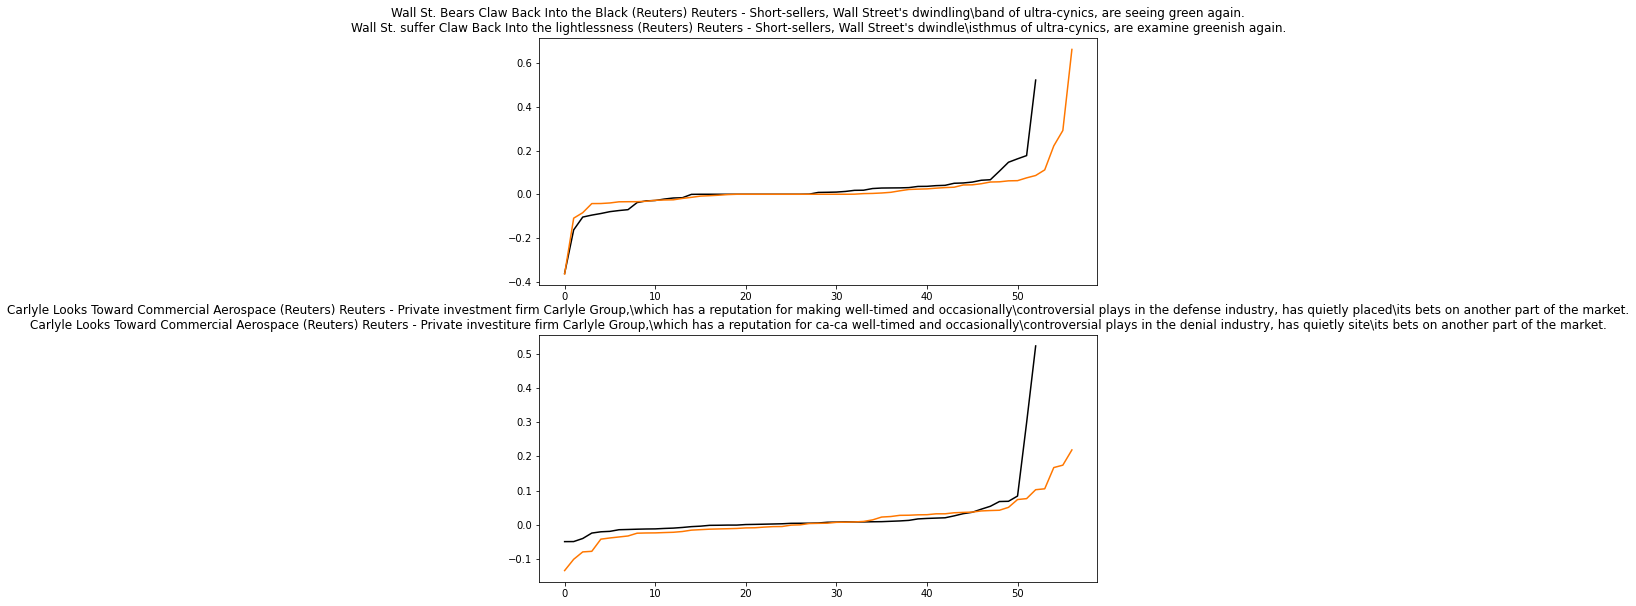

In [9]:
num_rows, _ = adversarial_df.shape
fig, axs = plt.subplots(num_rows, 1, figsize=(10, num_rows*5))

for i in range(num_rows):
  axs[i].plot(np.sort(adversarial_df.iloc[i].original_attribution), color="black")
  axs[i].plot(np.sort(adversarial_df.iloc[i].perturbed_attribution), color="#FF7700")
  axs[i].set_title(f"{adversarial_df.iloc[i].original_text}\n{adversarial_df.iloc[i].perturbed_text}")

## Preprocess the Dataframe

In [79]:
max_tokens_original = adversarial_df["original_attribution"].apply(lambda x: len(x)).max()
max_tokens_perturbed = adversarial_df["perturbed_attribution"].apply(lambda x: len(x)).max()


X_original = adversarial_df["original_attribution"].apply(lambda x: np.array(x)).to_numpy()
X_perturbed = adversarial_df["perturbed_attribution"].apply(lambda x: np.array(x)).to_numpy()

Y_original = np.zeros(X_original.shape[0])
Y_perturbed = np.ones(X_perturbed.shape[0])

X = np.concatenate((X_original, X_perturbed))
Y = np.concatenate((Y_original, Y_perturbed))

# Fix the padding to alywas match n
max_tokens = max(max_tokens_original, max_tokens_perturbed)
X = [np.pad(x, (0, max_tokens-x.shape[0])) for x in X]

# Convert array of arrays to 2D-array
X = np.stack(X)

X, Y = sklearn.utils.shuffle(X, Y, random_state=42)

## Train an Adversarial Detector

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, Y, random_state=42, shuffle=True, train_size=0.7
)
gnb = sklearn.naive_bayes.GaussianNB()
gnb.fit(x_train, y_train)
preds = gnb.predict(x_test)
# draw_confusion_matrix(y_test, preds, "Gaussian Naive Bayes")
print(sklearn.metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.49      0.78      0.60        27
         1.0       0.33      0.12      0.18        25

    accuracy                           0.46        52
   macro avg       0.41      0.45      0.39        52
weighted avg       0.41      0.46      0.40        52



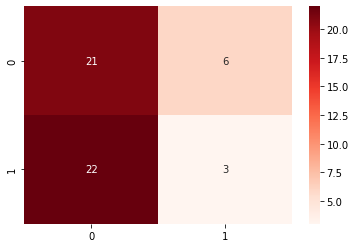

In [81]:
import seaborn as sns

sns.heatmap(sklearn.metrics.confusion_matrix(y_test, preds), annot=True, cmap="Reds")